# _[CV HW1](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/10-CV/03-segdet/Homework%20Viola-Jones.ipynb)_


[Georgia Tech face database](http://www.anefian.com/research/face_reco.htm "Ara Nefian Face Recognition Page")

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd
import sklearn.metrics

In [2]:
cv2.__version__

'4.1.0'

In [3]:
import glob
import os

## *Загрузка данных*

In [4]:
image_paths = sorted(glob.glob('gt_db/*/*'))
label_paths = sorted(glob.glob('labels/*'))

\*___Внимание___: в подкаталоге `s33` архива [`gt_db.zip`](http://www.anefian.com/research/gt_db.zip) содержится посторонний файл: `pspbrwse.jbf`. Его пришлось удалить, чтобы можно было простым поиском через [`glob`](https://docs.python.org/3/library/glob.html "glob — Unix style pathname pattern expansion") сопоставить файл с изображением файлу с его разметкой.

In [5]:
len(image_paths), len(label_paths)

(751, 750)

In [6]:
(
    pd.DataFrame([ f.split(os.path.sep) for f in glob.glob('gt_db/*/*') ], columns=['dir', 'subdir', 'file'])
    .groupby('subdir')
    .count()
    .nlargest(2, 'file')
)

,dir,file
subdir,,
s33,16,16
s01,15,15


In [7]:
pspbrwse_jbf = 'gt_db/s33/pspbrwse.jbf'
if os.path.exists(pspbrwse_jbf):
    os.unlink(pspbrwse_jbf)
    image_paths = sorted(glob.glob('gt_db/*/*'))
    
assert(len(image_paths) == len(label_paths))

Загрузка координат рамок:

In [8]:
true_boxes = np.zeros((len(label_paths), 4)).astype(np.int)

for i, label_path in enumerate(label_paths):
    with open(label_path) as label_file:
        true_boxes[i] = np.array(label_file.readline().split()[:-1]).astype(np.int)

Загрузка изображений:

In [9]:
images = [ cv2.imread(path) for path in image_paths ]

Для примера отрисуем произвольное изображение с заданной рамкой лица.

In [10]:
def show_image_with_bounding_boxes(image, boxes, colors):
    img = np.copy(image)
    for i, box in enumerate(boxes):
        xA, yA, xB, yB = box
        cv2.rectangle(img, (xA, yA), (xB, yB), colors[i], thickness=2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

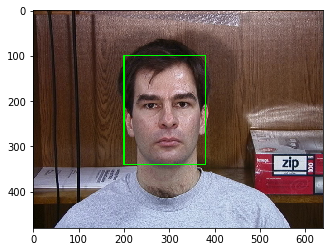

In [11]:
show_image_with_bounding_boxes(images[0], [ true_boxes[0] ], [ (0, 255, 0) ])

## *Детекция*

[Предобученная модель](https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml "opencv/haarcascade_frontalface_default.xml at master · opencv/opencv") для детекции лиц:

In [12]:
face_cascade = cv2.CascadeClassifier('../../03-segdet/data/haarcascade_frontalface_default.xml')

Как и в [примере с семинара](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/10-CV/03-segdet/tasks/003-viola-jones.ipynb), будем использовать метод [CascadeClassifier::detectMultiScale](https://docs.opencv.org/master/d1/de5/classcv_1_1CascadeClassifier.html#aaf8181cb63968136476ec4204ffca498 "OpenCV: cv::CascadeClassifier Class Reference"). Значения его параметров `scaleFactor` и `minNeighbors` возьмём из этого же примера.

In [13]:
def detect_face(cascade, img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # пользуемся априорным знанием, что на изображении только один человек
    # (но бывает, что алгоритм не обнаруживает лицо)
    rects = cascade.detectMultiScale(gray, 1.3, 3)
    x, y, w, h = rects[0] if 0 < len(rects) else [0]*4
    # возвращаем прямоугольник в формате с двумя координатами
    return [x, y, x + w, y + h]

Проиллюстрируем работу детектора на том же самом изображении:

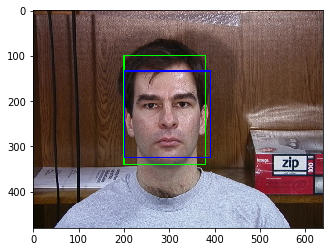

In [14]:
show_image_with_bounding_boxes(images[0],
                               [ true_boxes[0], detect_face(face_cascade, images[0]) ], 
                               [ (0, 255, 0), (255, 0, 0) ])

Но бывает, что детекция не получается:

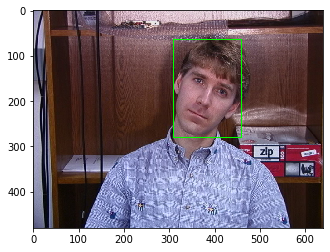

In [15]:
show_image_with_bounding_boxes(images[79],
                               [ true_boxes[79] ], 
                               [ (0, 255, 0) ])

In [16]:
detect_face(face_cascade, images[79])

[0, 0, 0, 0]

Детекция для всех изображений:

In [17]:
pred_boxes = [ detect_face(face_cascade, img) for img in images ]

## *Метрики качества*

### *IoU*
Функция для расчёта метрики **IoU** *(Intersection over Union)* взята из [статьи](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ "Intersection over Union (IoU) for object detection - PyImageSearch"):

In [18]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [19]:
ious = [ bb_intersection_over_union(*x) for x in zip(true_boxes, pred_boxes) ]

Для первого изображения выше значение **IoU**, ожидаемо, довольно высокое.

In [20]:
print(f'{ious[0]:.3f}')

0.752


Для неудавшихся детекций **IoU** получается равным *0*, что нас вполне устраивает.

In [21]:
ious[79]

0.0

### *Процент успешных детекций*

Эквивалентен метрике ***accuracy*** для случая, когда у нас один класс.

In [22]:
iou_threshold = 0.7

In [23]:
match_boxes = (np.array(ious) >= iou_threshold).astype(np.int)

np.unique(match_boxes, return_counts=True)

(array([0, 1]), array([550, 200], dtype=int64))

In [24]:
detection_accuracy = sklearn.metrics.accuracy_score(np.ones(len(match_boxes), dtype=np.int),
                                                    match_boxes)

print('Detection accuracy (by IoU): ' f'{100 * detection_accuracy:.2f}%')

Detection accuracy (by IoU): 26.67%


### *Precision и recall детектора*

В данном случае предлагается следующая интерпретация (&copy; *@filatovartm*):

> **TP :** наши детекции, которые пересекаются сильнее порога ($\ge 0.7$)
>
> **FP :** мы сказали что есть детекция, но поставили её не точно: пересечение с коробкой из разметки меньше порога ($\lt 0.7$)
>
> **FN :** об этом можно думать так: если мы не пересеклись с коробкой из разметки, то мы назвали эту коробку негативным классом, значит это FN
>
> **TN :** в данном случае не определено, но для вычисления ***precision*** и ***recall*** не требуется.

Посчитаем метрики исходя из этих соображений.

In [25]:
ious = np.array(ious)

tp = np.sum(ious >= iou_threshold)
fn = np.sum(ious == 0.0)
fp = np.sum(ious < iou_threshold) - fn

assert(len(ious) == tp + fp + fn)

print(f'Confusion matrix:\n{np.array([tp, fp, fn, 0]).reshape(2, -1)}')

Confusion matrix:
[[200 519]
 [ 31   0]]


In [26]:
precision = tp / (tp + fp)

recall = tp / (tp + fn)

print(f'Detection precision: {precision:.3f}, recall: {recall:.3f}')

Detection precision: 0.278, recall: 0.866
